# $\textit{Detección de ondas gravitatorias}$
$\textit{Estimación Espectral No Paramétrica}$

In [2]:
#En ppio hay que elegir entre 32sec • 4KHz o 4096sec • 4KHz. Esto porque el evento esta alrededor de los 2Khz.
#Ademas, usamos el dataset de 4096 seg porque el ruido es localmente estacionario (hay que probarlo).

In [3]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_theme()

In [5]:
# these 4096 second files are useful for computing more accurate psds
largeFilenamePart = {'GW150914': 'GWOSC_4KHZ_R1-1126257415-4096.hdf5'}
fn_H1 = './Data/H-H1_' + largeFilenamePart['GW150914']
fn_L1 = './Data/L-L1_' + largeFilenamePart['GW150914']

# this is the approximate event time which is used in the papers
time_center = 1126259462

# get sample rate from the H1 data file
with h5py.File(fn_H1, 'r') as hdf_file:
    dt = hdf_file['strain/Strain'].attrs['Xspacing']
fs = int(1.0/dt)
print("Using sample rate of {0} Hz found in file: {1}".format(fs, fn_H1))

Using sample rate of 4096 Hz found in file: ./Data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [6]:
import readligo as rl
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

In [7]:
len(strain_H1)

16777216

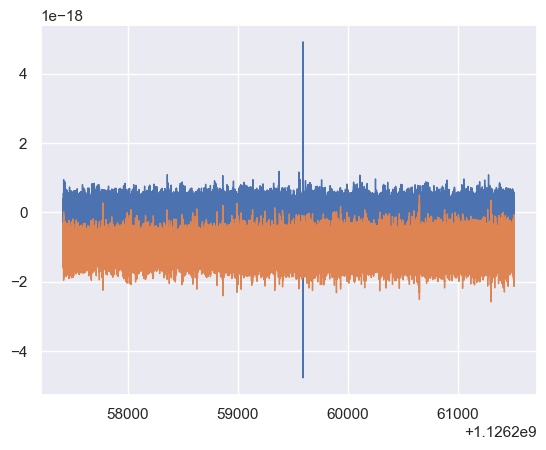

In [8]:
plt.plot(time_H1, strain_H1, linewidth=1)
plt.plot(time_L1, strain_L1, linewidth=1)

In [9]:
time = time_H1
indxt_around = np.where((time >= time_center - 512) & (time < time_center + 512))

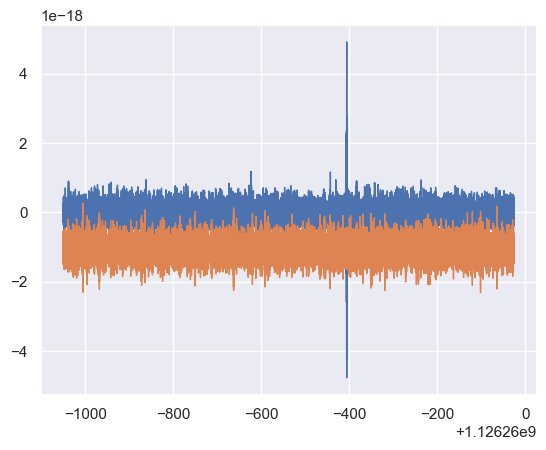

In [10]:
plt.plot(time_H1[indxt_around], strain_H1[indxt_around], linewidth=1)
plt.plot(time_L1[indxt_around], strain_L1[indxt_around], linewidth=1)

# $\textit{Elegimos la ventana}$

In [88]:
from numpy.fft import fft
from numpy.fft import fftshift, fftfreq

In [381]:
N = 4096
n = np.linspace(0,N-1,N)

SquareW = np.full(N, 1) #Square window
TriangW = N/2 - np.abs(n-(N-1)/2) #Triangular window
HanW = 0.5 - 0.5 * np.cos((2*np.pi*n)/(N-1)) #Hanning window
HamW = 0.54 - 0.46 * np.cos((2*np.pi*n)/(N-1)) #Hamming window
BlkHarrW = 0.36 - 0.49 * np.cos((2*np.pi*n)/(N-1)) + 0.14 * np.cos((4*np.pi*n)/(N-1)) - 0.012 * np.cos((6*np.pi*n)/(N-1)) #Blackman-Nuttall

currWindow = SquareW #Choose window

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_1156\1563464483.py:7: RuntimeWarning: divide by zero encountered in log10
  response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))


(-0.5, 0.5, -120.0, 0.0)

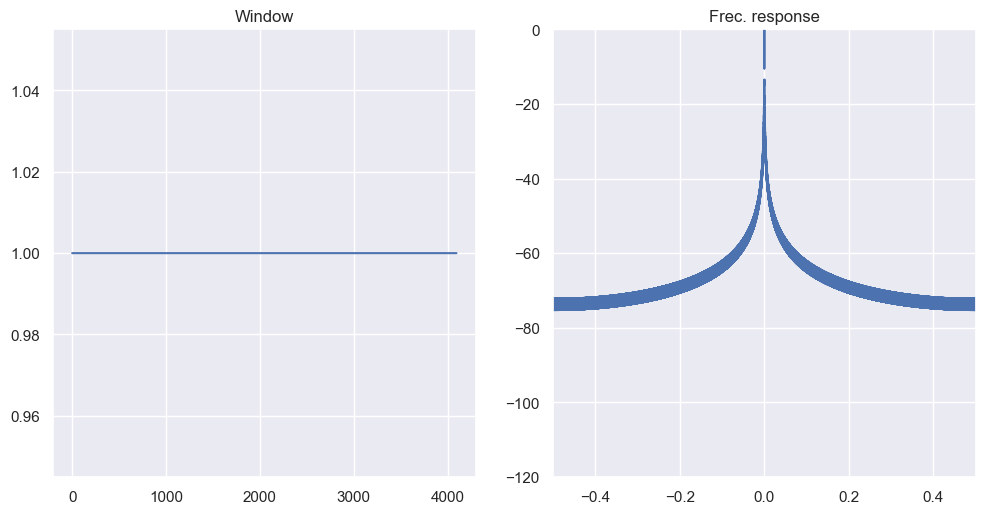

In [382]:
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=0)
fig.set_figwidth(10)

A = fft(currWindow, N*4) / (N/2.0) #Por que es necesario el padding N*8?
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))


axs[0].set_title("Window")
axs[0].plot(currWindow)

axs[1].set_title("Frec. response")
axs[1].plot(freq, response)
axs[1].axis([-0.5, 0.5, -120, 0])
#axs[1].set_yscale('log')

# $\textit{Agarramos los datos sin el evento en ventanas}$

In [383]:
after = np.max(indxt_around)
before = np.min(indxt_around)
evTol = N

#Getting an neighbourhood of the event
strain_H1_after_noise = strain_H1[:after]
strain_L1_after_noise = strain_L1[:after]
strain_H1_before_noise = strain_H1[before:]
strain_L1_before_noise = strain_L1[before:]

getChunckForward = lambda lst: [lst[i:i + evTol] for i in range(0, len(lst), evTol)][:-1]
getChunckDownward = lambda lst: [lst[len(lst)-evTol-i:len(lst)-i] for i in range(0, len(lst), evTol)][:-1]

#Chequear el tama;o de los chuncks para getChunckDownward

noiseH1After = getChunckForward(strain_H1_after_noise)
noiseL1After = getChunckForward(strain_L1_after_noise)
noiseH1Before = getChunckDownward(strain_H1_before_noise)
noiseL1Before = getChunckDownward(strain_L1_before_noise)

In [384]:
len(noiseH1After)

2558

In [385]:
len(noiseH1Before[len(noiseH1Before)-1])

4096

# $\textit{Calculamos la PSD}$

In [344]:
def estimateAutocorrelation(seq):
    
    N = len(seq)
    rx = np.zeros(N)
    
    for l in range(N):
        acc = 0
        for n in range(N-l):
            acc += (seq[n+l]) * np.conjugate(seq[n])
        rx[l] = acc / N
    
    return rx


In [386]:
def PSD(seq, L):
    rv = estimateAutocorrelation(seq)[:L]
    rx = fft(rv) / (L/2.0)
    Rx = np.abs(fftshift(rx))
    return Rx

# $\textit{Periodogram}$

In [392]:
exampleSize = 10
PSDs = [PSD(currWindow * noiseH1After[i], N//4) for i in range(len(noiseH1After))[:exampleSize]]

Text(0.5, 1.0, 'Periodogram')

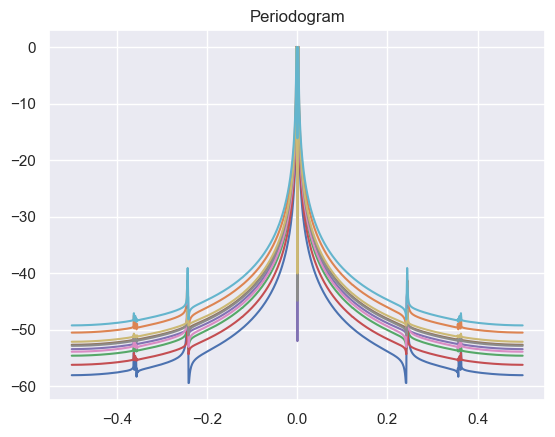

In [393]:
for i in range(len(PSDs)):
    A = PSDs[i]
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs((A / abs(A).max())))
    plt.plot(freq, response)
plt.title("Periodogram")

# $\textit{Periodogram Smoothing}$

In [396]:
lenght = len(strain_H1_after_noise[:N])
dt = np.linspace(0,lenght-1,lenght)
window = lenght/2 - np.abs(dt-(lenght-1)/2) 

SmoothingPSDs = PSD(window * strain_H1_after_noise[:lenght], lenght//10)
Period = np.divide(SmoothingPSDs, 2*len(strain_H1_after_noise)+1)

freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs((A / abs(A).max())))
plt.plot(freq, response)
plt.title("Periodogram smoothing")

# $\textit{Periodogram Averaging}$

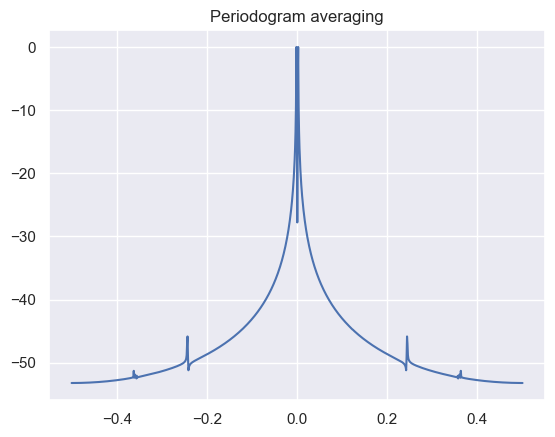

In [395]:
A = np.sum(PSDs, axis=0)
freq = np.linspace(-0.5, 0.5, len(A))
response = 20 * np.log10(np.abs((A / abs(A).max())))
plt.title("Periodogram averaging")
plt.plot(freq, response)

In [391]:
def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht